In [1]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import pandas as pd
import time as ttime

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log

## Own python package
from synthetics import *

%matplotlib inline
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Developpement"

## Make Nice Plots

In [2]:
plt.style.use("ggplot")
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Theory 
We will compute synthetic Cross-correlations between vertical components, using the formulation given in Tomasetto et al.(2024). Using the representation theorem and assuming spatially uncorrelated sources one can write the cross-correlation function between sensors A and B as:

$ C(r_A, r_B, t) = \mathcal{FT}^{-1}\left[ \int_{\partial D} G(r_A, r, f) G^*(r_B, r, f) S(r,f) dr \right] $

with:
- $ G(r_A, r, f) $ the Green's function between a source in $ r $ and station A in $ r_A $. Here computed in AxiSEM.
- $ S(r,f) $ the source PSD at position $ r $. Here given by the square of equivalent vertical force amplitude computed in microseismic_sources.ipynb.
- $^*$ denotes the complex conjugate.
- $ \partial D$ the domain of potential sources, here, the ocean's surface.
- $ \mathcal{FT}^{-1}$ the Fourier transform.

## Create Synthetic Waveforms Database

In the following, we will use an AxiSEM archive file of seismic waveforms computed in iasp91 model and sampled at 1 Hz.

First we will read and plot the archive.

In [3]:
## Open Archive 

fe, time, N = get_synthetic_info()

distance = np.arange(0, 180.1, 0.1)
M = len(distance)
archive = np.zeros((M, N))

for i in range(M):
    archive[i,:] = open_axisem(distance[i])


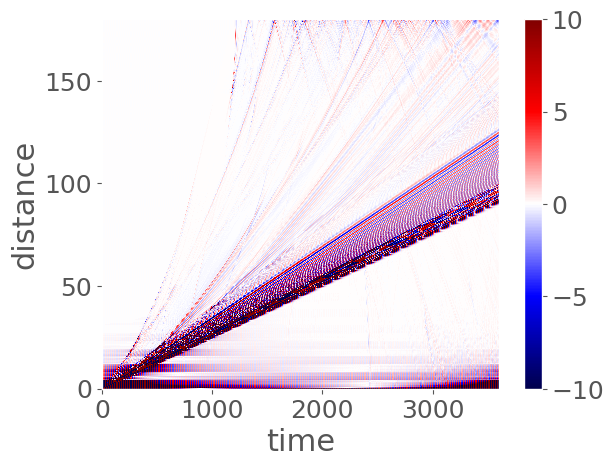

In [4]:
## Plot archive
plt.figure()
plt.pcolormesh(time, distance, archive,cmap='seismic', vmin=-10, vmax = 10)
plt.colorbar()
plt.xlabel('time')
plt.ylabel('distance')
plt.xlim(0, 3600)
plt.show()

## Tapering

Then we taper the synthetics waveforms between two given surface waves velocities.

In [5]:
## Taper
Umin = 2.8
Umax = 3.9

file_name_taper = './RUN_single_vertforce_iasp91_1.s_256c_3600_tapered.s.h5'

if os.path.isfile(file_name_taper):
    print('Tapered archive already exists')
    ## Open tapered archive
    h5_file = h5py.File(file_name_taper, 'r')
    tapered_archive = h5_file['WAVEFORMS'][:]
    
else:
    tapered_archive = taper_axisem_archive(time, distance, umin = Umin, umax=Umax)


Tapered archive already exists


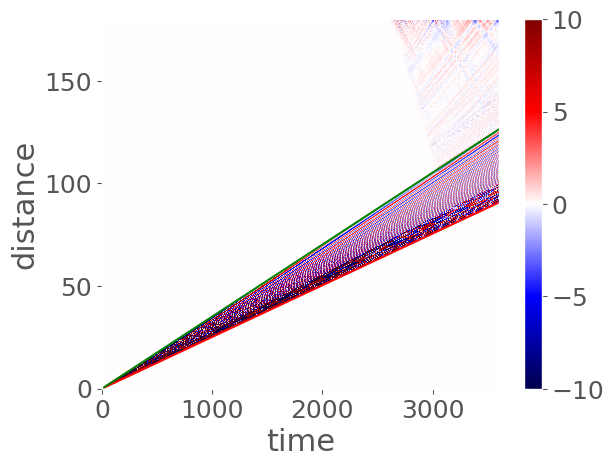

In [6]:
## Plot Tapered archive 

plt.figure()
plt.pcolormesh(time, distance, tapered_archive, cmap='seismic', vmin=-10, vmax = 10)
plt.plot(distance*(np.pi*6371)/180/Umin, distance, 'r')
plt.plot(distance*(np.pi*6371)/180/Umax, distance, 'g')
plt.colorbar()
plt.xlabel('time')
plt.ylabel('distance')
plt.xlim(0, 3600)
plt.show()


In [7]:
file_name_spectrum = 'spectrum_archive_tapered.h5'

if os.path.isfile(file_name_spectrum):
    print('Spectrum archive already exists')
    ## Open Spectrum archive
    h5_file = h5py.File(file_name_spectrum, 'r')
    spectrum_archive = h5_file['SPECTRUM'][:]
    frequency = h5_file['frequency'][:]
    distance = h5_file['distance'][:]
    print(spectrum_archive.shape)
else:
    ## Create Spectrum archive from the tapered one
    create_spectrum_archive(time, distance, tapered_archive)

100%|██████████| 1801/1801 [00:00<00:00, 14930.33it/s]


# Synthetics Computation

## Spatial Extent

In [8]:
## Spatial Exent
lon_min = -20
lon_max = 40
lat_min = 10
lat_max = 70

extent = [lon_min, lon_max, lat_min, lat_max]

## Station Pairs and Metadata

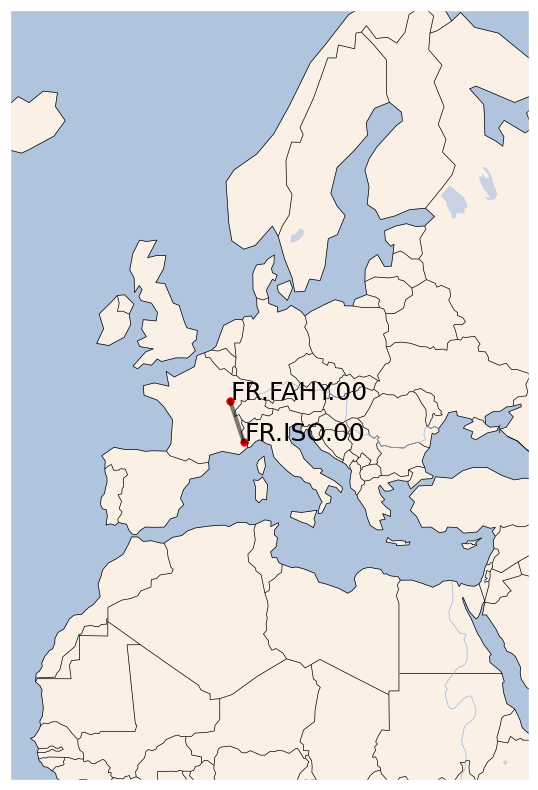

In [9]:
## Station Pairs Metadata
df = pd.read_csv('stations_pair.txt', sep=',', header=None, index_col=False, names=['idA', 'idB', 'latA', 'latB', 'lonA', 'lonB'], dtype={'idA':str, 'idB':str, 'latA':float, 'latB':float, 'lonA':float, 'lonB':float}, engine='python')
# ## Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND, color='linen', zorder=0)
ax.add_feature(cfeature.OCEAN, color='lightsteelblue', zorder=0)
for i in range(len(df)):
    ax.annotate(df.idA[i], (df.lonA[i]+0.1, df.latA[i]+0.1), transform = ccrs.PlateCarree(), family = 'sans-serif')
    ax.annotate(df.idB[i], (df.lonB[i]+0.1, df.latB[i]+0.1), transform = ccrs.PlateCarree(), family = 'sans-serif')
    ax.plot((df.lonA[i], df.lonB[i]),(df.latA[i], df.latB[i]), transform = ccrs.PlateCarree(), color='k', alpha=0.5, linewidth=3)
df.plot.scatter(x='lonA', y='latA', s=30, ax=ax, c='r', transform = ccrs.PlateCarree())
df.plot.scatter(x='lonB', y='latB', s=30, ax=ax, c='r', transform = ccrs.PlateCarree())
plt.show()

## Dates 

In [10]:
## Dates
start = datetime(2020, 9, 25, 0, 0, 0)
end = datetime(2020, 9, 28, 0, 0, 0)

dates = pd.date_range(start, end, freq='3H')

dates_vector = create_date_vect(dates)

## Open WAVEWATCHIII Equivalent Force Amplitude

In [11]:
## Open Model
path_model = '../../ocean_source/pr_oceanswell/rayleigh/F/'

## Open Syngine Archive 

In [12]:
## Open GF archive info
fe , freq, distance, spectrum_synth = open_archive('spectrum_archive_tapered.h5')
N_time = len(time)

## Synthetic Cross-correlation Computation

In [13]:
## Compute CCF and save it
### Station Pair Info
id_A = df.idA[0]
id_B = df.idB[0]
coords_staA = (df.lonA[0], df.latA[0])
coords_staB = (df.lonB[0], df.latB[0])

#### Keep Correlations
corr_3h = np.zeros((len(dates_vector), N_time))

### Date Info
for i, date_vect in enumerate(dates_vector):
    ### CCF
    filename_ccf = './CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]) # File Name Understandable

    if os.path.exists(filename_ccf):  # Check if file already exists
        print('%s already computed'%filename_ccf)
        corr = xr.open_dataarray(filename_ccf)
    else:  # if not, compute CCF
        t1 = ttime.perf_counter()
        corr, time_corr = ccf_computation(coords_staA, coords_staB, path_model, date_vect, spectrum_synth,extent=extent, fe=fe, N=N_time, comp='Z')
        t2 = ttime.perf_counter()
        print(" Time for station pair: ", id_A, id_B, " elapsed: ", t2-t1)
        try:
            corr.to_netcdf('./CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]))
        except:
            print("make directory")
            os.mkdir('./CCF')
            corr.to_netcdf('./CCF/ccf_%s_%s_%d%02d%02d%02d.nc'%(id_A, id_B, date_vect[0],date_vect[1],date_vect[2],date_vect[3]))
    
    corr_3h[i, :] = corr.values 
    
    print(np.max(abs(corr.values)))

PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  12.860828260999995
make directory
2.2981350433362835e-05
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  12.143250416
2.2438511744220693e-05
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  11.648064521999999
1.675723862545309e-05
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  11.888705943999994
9.989842365676678e-06
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  11.629381275
1.1676155921614041e-05
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  11.758036774999994
4.6440013304265705e-05
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  11.887239985999997
8.289106710258171e-05
PSD shape (121, 121, 1800)
 Time for station pair:  FR.ISO.00 FR.FAHY.00  elapsed:  11.856121686999984
8.0353685764367

## Plot

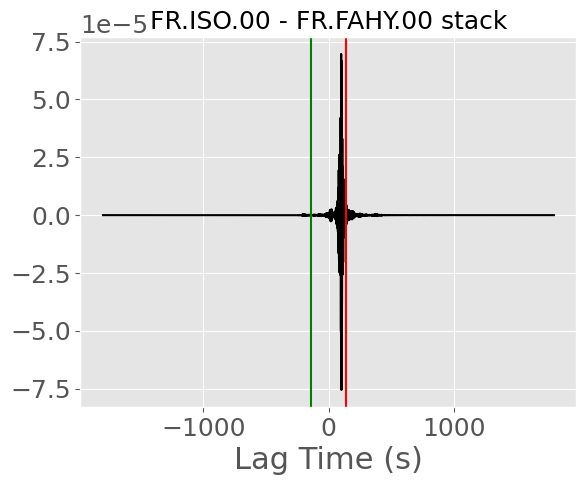

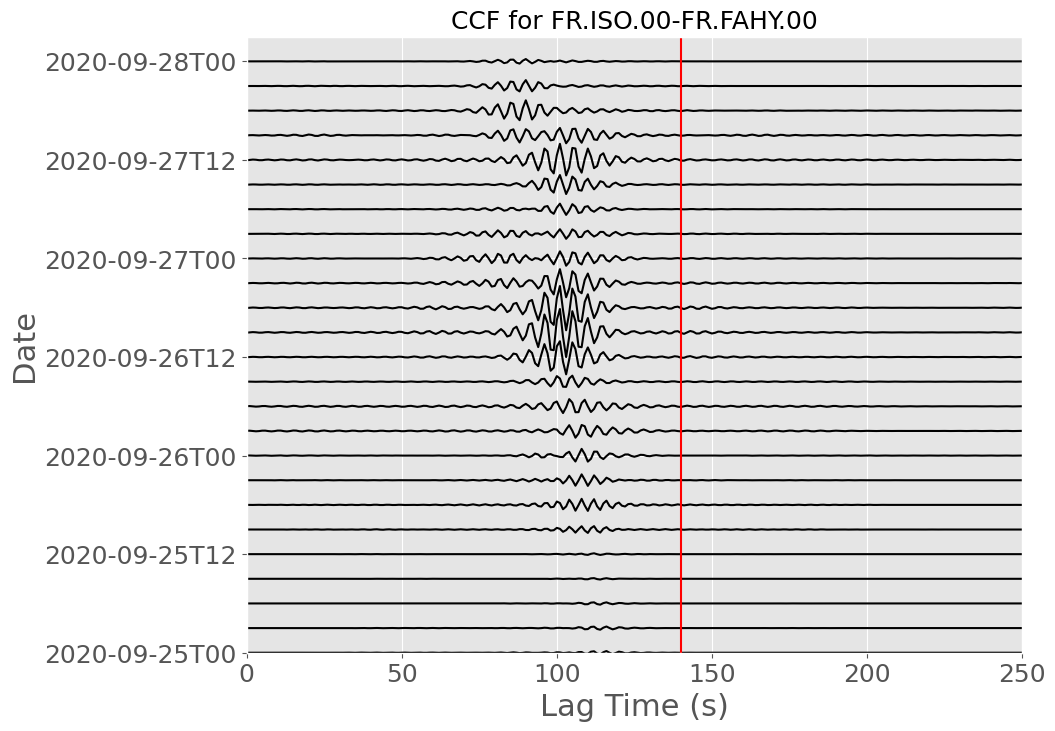

In [14]:
## Plot stack 

plt.figure()
plt.plot(corr.time, np.mean(corr_3h, axis=0), 'k')
plt.axvline(x=140, color='r')
plt.axvline(x=-140, color='g')
# plt.xlim(-250, 250)
plt.xlabel('Lag Time (s)')
plt.title('%s - %s stack'%(id_A, id_B))
plt.show()

## Plot CCF
normalize = np.max(abs(corr_3h))

fig, ax = plt.subplots(figsize=(10,8))
im = ax.plot(corr.time, corr_3h.T/normalize + np.arange(len(dates_vector)), 'k') #, extent=[-300, 300, 0, len(dates_vector)], aspect='auto', cmap='RdYlGn')
ax.set_xlabel('Lag Time (s)')
ax.set_ylabel('Date')
ax.set_title('CCF for %s-%s'%(id_A, id_B))
ax.set_xlim(0, 250)
ax.set_ylim(0, len(dates_vector))
ax.set_yticks(np.arange(len(dates_vector))[::4])
ax.set_yticklabels(dates[::4].strftime('%Y-%m-%dT%H'))
plt.axvline(x=140, color='r')
#fig.colorbar(im, ax=ax)
plt.show()